<a href="https://colab.research.google.com/github/ohbigkite/2023_LG_AImers/blob/main/%5B%ED%83%9C%EC%97%B0%5DLGBM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%A0%9C%ED%92%88_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1(mean_encoding)_0827.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/LG_Aimers

/content/drive/MyDrive/LG_Aimers


In [4]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor

In [5]:
import random
import os
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

### Train / Test dataset 만들어주기 // 회귀 형태로 데이터 변환 / 파생변수 추가



In [6]:
train_data = pd.read_csv('./train.csv').drop(columns=[ '제품'])

In [7]:
train_cluster = pd.read_csv('./train_cluster_only.csv', encoding = 'cp949')
brand_cluster = pd.read_csv('./brand_cluster_only.csv', encoding = 'cp949')

In [8]:
train_data = pd.merge(train_data, brand_cluster.loc[:,['브랜드', 'cluster']], on = '브랜드')

In [9]:
train_data['train_cluster'] = train_cluster['cluster']

In [10]:
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])


In [11]:
# 회귀 형태로 데이터 변환 - 날짜별로 하나의 행이 되도록 melt 시켜줌
not_day_index = train_data.columns[:5]
not_day_index = not_day_index.append(train_data.columns[464:])
train_data = train_data.melt(id_vars = not_day_index)
train_data

,ID,대분류,중분류,소분류,브랜드,cluster,train_cluster,variable,value
0,0,1,6,37,0,0,5,2022-01-01,0
1,1,2,7,43,1,0,4,2022-01-01,0
2,2,2,7,43,1,0,1,2022-01-01,0
3,3,2,7,43,1,0,1,2022-01-01,0
4,4,0,0,2,2,4,1,2022-01-01,0
...,...,...,...,...,...,...,...,...,...
7293505,15885,2,7,41,3169,5,5,2023-04-04,0
7293506,15886,2,7,43,3169,5,1,2023-04-04,3
7293507,15887,2,7,43,3169,5,4,2023-04-04,0
7293508,15888,2,7,43,3169,5,6,2023-04-04,2


In [12]:
# ID 변수 mean_encoding
id_mean = train_data.groupby('ID')['value'].mean()

# 가존 변수에 encoded 된 값을 매핑
train_data['ID_mean'] = train_data['ID'].map(id_mean)

In [13]:
id_std = train_data.groupby('ID')['value'].std()
train_data['ID_std'] = train_data['ID'].map(id_std)

In [14]:
# 대분류 / 중분류 / 소분류 / 브랜드 mean_encoding

big_mean = train_data.groupby('대분류')['value'].mean()
train_data['big_mean'] = train_data['대분류'].map(big_mean)

big_std = train_data.groupby('대분류')['value'].std()
train_data['big_std'] = train_data['대분류'].map(big_std)

mid_mean = train_data.groupby('중분류')['value'].mean()
train_data['mid_mean'] = train_data['중분류'].map(mid_mean)

mid_std = train_data.groupby('중분류')['value'].std()
train_data['mid_std'] = train_data['중분류'].map(mid_std)

small_mean = train_data.groupby('소분류')['value'].mean()
train_data['small_mean'] = train_data['소분류'].map(small_mean)

small_std = train_data.groupby('소분류')['value'].std()
train_data['small_std'] = train_data['소분류'].map(small_std)

brand_mean = train_data.groupby('브랜드')['value'].mean()
train_data['brand_mean'] = train_data['브랜드'].map(brand_mean)

brand_std = train_data.groupby('브랜드')['value'].std()
train_data['brand_std'] = train_data['브랜드'].map(brand_std)


In [15]:
# 날짜 변수 분해
date = pd.to_datetime(train_data.variable)
train_data['year'] = date.dt.year
train_data['day'] = date.dt.weekday
train_data['month'] = date.dt.month
train_data['week'] = date.dt.weekofyear

<ipython-input-15-065e42fa1e63>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_data['week'] = date.dt.weekofyear


In [16]:
# 휴일 변수 추가
import holidays
date_list=pd.date_range(start='20220101', end='20230425', freq='D')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

In [17]:
train_data['holiday'] = train_data.variable.apply(lambda x: 1 if x in kr_holidays else 0)

In [18]:
# 월 주기 추가
train_data['sin_month'] = np.sin(2*np.pi*train_data.month/12)
train_data['cos_month'] = np.cos(2*np.pi*train_data.month/12)

In [19]:
# test dataset 형태도 맞춰주기
submit = pd.read_csv('./sample_submission.csv')
train_origin = pd.read_csv('./train.csv').drop(columns=[ '제품'])

In [20]:
test_data = pd.concat([train_origin.iloc[:,:5],submit.iloc[:,1:]], axis = 1)

In [21]:
test_data = pd.merge(test_data, brand_cluster.loc[:,['브랜드', 'cluster']], on = '브랜드')
test_data['train_cluster'] = train_cluster['cluster']

In [22]:
for col in categorical_columns:
    label_encoder.fit(test_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [23]:
not_day_index = test_data.columns[:5]
not_day_index = not_day_index.append(test_data.columns[26:])
test_data = test_data.melt(id_vars = not_day_index)
test_data

,ID,대분류,중분류,소분류,브랜드,cluster,train_cluster,variable,value
0,0,1,6,37,0,0,5,2023-04-05,0
1,1,2,7,43,1,0,4,2023-04-05,0
2,2,2,7,43,1,0,1,2023-04-05,0
3,3,2,7,43,1,0,1,2023-04-05,0
4,4,0,0,2,2,4,1,2023-04-05,0
...,...,...,...,...,...,...,...,...,...
333685,15885,2,7,41,3169,5,5,2023-04-25,0
333686,15886,2,7,43,3169,5,1,2023-04-25,0
333687,15887,2,7,43,3169,5,4,2023-04-25,0
333688,15888,2,7,43,3169,5,6,2023-04-25,0


In [24]:
test_data['ID_mean'] = test_data['ID'].map(id_mean)

In [25]:
test_data['ID_std'] = test_data['ID'].map(id_std)

In [26]:
# 대분류 / 중분류 / 소분류 / 브랜드 mean_encoding

test_data['big_mean'] = test_data['대분류'].map(big_mean)
test_data['big_std'] = test_data['대분류'].map(big_std)

test_data['mid_mean'] = test_data['중분류'].map(mid_mean)
test_data['mid_std'] = test_data['중분류'].map(mid_std)

test_data['small_mean'] = test_data['소분류'].map(small_mean)
test_data['small_std'] = test_data['소분류'].map(small_std)

test_data['brand_mean'] = test_data['브랜드'].map(brand_mean)
test_data['brand_std'] = test_data['브랜드'].map(brand_std)

In [27]:
date = pd.to_datetime(test_data.variable)
test_data['year'] = date.dt.year
test_data['day'] = date.dt.weekday
test_data['month'] = date.dt.month
test_data['week'] = date.dt.weekofyear

<ipython-input-27-62b702225efb>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_data['week'] = date.dt.weekofyear


In [28]:
test_data['holiday'] = test_data.variable.apply(lambda x: 1 if x in kr_holidays else 0)

In [29]:
# 월 주기 추가
test_data['sin_month'] = np.sin(2*np.pi*test_data.month/12)
test_data['cos_month'] = np.cos(2*np.pi*test_data.month/12)

In [30]:
# merge, groupby 시 순서 바뀌므로 날짜, id 기준 sort
train_data = train_data.sort_values(by = ['variable','ID'])
test_data = test_data.sort_values(by = ['variable','ID'])

In [31]:
train_data

,ID,대분류,중분류,소분류,브랜드,cluster,train_cluster,variable,value,ID_mean,...,small_std,brand_mean,brand_std,year,day,month,week,holiday,sin_month,cos_month
0,0,1,6,37,0,0,5,2022-01-01,0,0.747277,...,18.522052,0.747277,1.732482,2022,5,1,52,1,0.500000,0.866025
1,1,2,7,43,1,0,4,2022-01-01,0,1.281046,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
2,2,2,7,43,1,0,1,2022-01-01,0,2.259259,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
3,3,2,7,43,1,0,1,2022-01-01,0,3.459695,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
4,4,0,0,2,2,4,1,2022-01-01,0,2.668845,...,218.318130,3.065541,10.952871,2022,5,1,52,1,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15885,2,7,41,3169,5,5,2023-04-04,0,12.788671,...,15.272916,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293506,15886,2,7,43,3169,5,1,2023-04-04,3,4.559913,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293507,15887,2,7,43,3169,5,4,2023-04-04,0,3.884532,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293508,15888,2,7,43,3169,5,6,2023-04-04,2,2.302832,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000


### Train/ Validation split & K-fold

In [32]:
# X,Y 정의
y = train_data.loc[:, 'value']
X = train_data.drop(['value'], axis = 1)

In [33]:
X = X.drop(['ID','variable','대분류','중분류','소분류','브랜드'], axis = 1)

In [34]:
X

,cluster,train_cluster,ID_mean,ID_std,big_mean,big_std,mid_mean,mid_std,small_mean,small_std,brand_mean,brand_std,year,day,month,week,holiday,sin_month,cos_month
0,0,5,0.747277,1.732482,17.346933,316.388864,4.940139,21.733424,4.760824,18.522052,0.747277,1.732482,2022,5,1,52,1,0.500000,0.866025
1,0,4,1.281046,1.661762,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
2,0,1,2.259259,3.806495,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
3,0,1,3.459695,7.926794,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
4,4,1,2.668845,6.767128,20.492290,210.516792,20.784478,214.882044,21.737302,218.318130,3.065541,10.952871,2022,5,1,52,1,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,5,5,12.788671,27.463215,5.293661,22.985167,5.564876,23.825022,4.555223,15.272916,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293506,5,1,4.559913,10.291293,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293507,5,4,3.884532,5.439400,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293508,5,6,2.302832,2.821822,5.293661,22.985167,5.564876,23.825022,4.795049,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000


In [35]:
# 시간을 기준으로 15890개 item 묶어버리기 - for PSFA 스코어 계산
X = np.array(X).reshape(459, -1, 19)
y = np.array(y).reshape(459,-1)

In [36]:
# PSFA score 만들어주기 위해 대분류
indexs_bigcat={}
for bigcat in train_data['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_data[:15890].loc[train_data['대분류']==bigcat].ID)

indexs_bigcat.keys()

dict_keys([1, 2, 0, 4, 3])

In [37]:
def PSFA(pred, target):
    #target, pred 값은 (368, 15890) 형태 -> target.T = (15890, 368)
    PSFA = 1
    for bigcat in indexs_bigcat.keys():
        ids = indexs_bigcat[bigcat]
        for day in range(pred.shape[0]):
            total_sell = np.sum(target.T[ids, day]) # day별 총 판매량
            pred_values = pred.T[ids, day] # day별 예측 판매량
            target_values = target.T[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values)
            diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (pred.shape[0] * 5)


    return PSFA

# Test dataset 마지막 21일로 설정해서!

In [38]:
y_test, X_test = y[:21], X[:21]
y_train, X_train = y[:-21], X[:-21]

In [39]:
print(X_train.shape) # (368, 15890, 9) : 368일 159890 id, 9개 feature
print(y_train.shape) # (368, 15890) : 368일 15890 -> y_train.reshape(-1) : (1445990,1)

(438, 15890, 19)
(438, 15890)


In [40]:
X

array([[[ 0.00000000e+00,  5.00000000e+00,  7.47276688e-01, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        [ 0.00000000e+00,  4.00000000e+00,  1.28104575e+00, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        [ 0.00000000e+00,  1.00000000e+00,  2.25925926e+00, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        ...,
        [ 5.00000000e+00,  4.00000000e+00,  3.88453159e+00, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        [ 5.00000000e+00,  6.00000000e+00,  2.30283224e+00, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        [ 5.00000000e+00,  1.00000000e+00,  2.17864924e-03, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01]],

       [[ 0.00000000e+00,  5.00000000e+00,  7.47276688e-01, ...,
          0.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        [ 0.00000000e+00,  4.00000000e+00,  1.28104575e+00, ...,
          0.00000000e+00,  5.00000000e

### lgbm

In [41]:
X_train.shape

(438, 15890, 19)

In [42]:
X_train.shape[2]

19

In [43]:
params = {'metric': 'rmse', 'random_state' : 42}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train.reshape(-1,X_train.shape[2]), y_train.reshape(-1)) # (1445990,9) / (1445990,1)
y_pred = lgbm.predict(X_test.reshape(-1,X_train.shape[2])) # (1445990,9)
y_pred = np.maximum(y_pred, 0) # (1445990,1)
y_pred = np.round(y_pred, 0).astype(int)
y_pred = y_pred.reshape(y_test.shape)

psfa =  PSFA(y_pred, y_test)
print(psfa)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 6959820, number of used features: 19
[LightGBM] [Info] Start training from score 18.347763
0.44624065402796215


<ipython-input-37-84f90e391bd0>:13: RuntimeWarning: invalid value encountered in divide
  diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)


In [44]:
y_test.reshape(-1).shape

(333690,)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

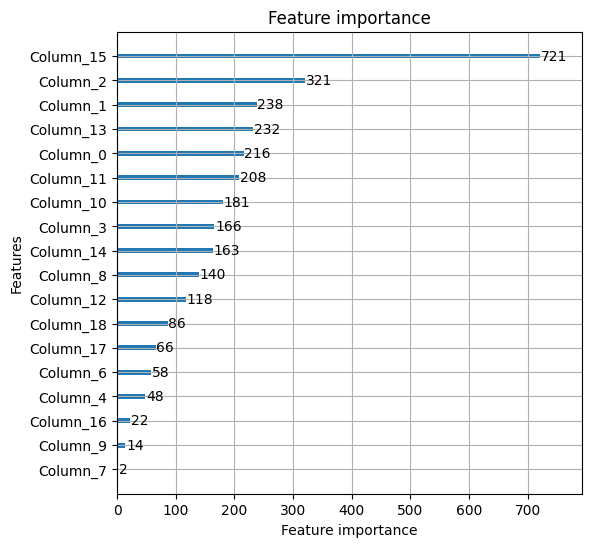

In [45]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize = (6,6))
plot_importance(lgbm, ax=ax)

### 테스트 데이터에 적용(submit)

In [46]:
test_data= test_data.drop(['variable'], axis = 1)

In [47]:
test_y = test_data.loc[:, 'value']
test_X = test_data.drop(['value'], axis = 1)

In [48]:
test_X = test_X.drop(['ID','대분류','중분류','소분류','브랜드'], axis = 1)

In [49]:
test_X.shape

(333690, 19)

In [50]:
train_data

,ID,대분류,중분류,소분류,브랜드,cluster,train_cluster,variable,value,ID_mean,...,small_std,brand_mean,brand_std,year,day,month,week,holiday,sin_month,cos_month
0,0,1,6,37,0,0,5,2022-01-01,0,0.747277,...,18.522052,0.747277,1.732482,2022,5,1,52,1,0.500000,0.866025
1,1,2,7,43,1,0,4,2022-01-01,0,1.281046,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
2,2,2,7,43,1,0,1,2022-01-01,0,2.259259,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
3,3,2,7,43,1,0,1,2022-01-01,0,3.459695,...,13.839676,2.333333,5.239330,2022,5,1,52,1,0.500000,0.866025
4,4,0,0,2,2,4,1,2022-01-01,0,2.668845,...,218.318130,3.065541,10.952871,2022,5,1,52,1,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15885,2,7,41,3169,5,5,2023-04-04,0,12.788671,...,15.272916,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293506,15886,2,7,43,3169,5,1,2023-04-04,3,4.559913,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293507,15887,2,7,43,3169,5,4,2023-04-04,0,3.884532,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000
7293508,15888,2,7,43,3169,5,6,2023-04-04,2,2.302832,...,13.839676,3.928468,12.963316,2023,1,4,14,0,0.866025,-0.500000


In [51]:
test_X = np.array(test_X).reshape(21, -1, 19)
test_y = np.array(test_y).reshape(21,-1)

In [52]:
test_y.shape

(21, 15890)

In [53]:
pred = lgbm.predict(test_X.reshape(-1,19)) # (1445990,9)
pred = np.maximum(pred, 0) # (1445990,1)
pred = np.round(pred, 0).astype(int)
pred = pred.reshape(test_y.shape)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:,1:] = pred.T
submit.to_csv('./baseline_submit_lgbm_ver5.csv', index=False)